# **Final Project Task 4 - Census Modeling Clustering**

Requirements:

Load Data
- Use the preprocessed dataset from Task 1.

Prepare Features
- Feature Selection:
    - Select relevant numerical and categorical features.
    - Note: K-Means works best with numerical data.
- Data Preprocessing:
    - Be sure you have normalized numerical features (e.g., using MinMaxScaler or StandardScaler) and categorical features encoded properly (e.g., One-Hot Encoding or Ordinal Encoding).
    
Clustering Model Implementation
- Apply K-Means Clustering:
    - Experiment with different values of K (number of clusters).
    - Use the Elbow Method to determine the optimal number of clusters:
    - Use yellowbrick.cluster.KElbowVisualizer to find the best K.
    - Calculate the Silhouette Score to evaluate cluster separation.
- Alternative Clustering Approaches:
    - Experiment with Hierarchical Clustering.
    - Experiment with DBSCAN

Visualize & Interpret Clusters
- Dimensionality Reduction:
    - Apply PCA or t-SNE to reduce dimensions and visualize clusters in 2D.
- Cluster Analysis:
    - Plot the clusters in 2D space.
    - Identify key characteristics of each group.
    - Use only numerical variables to interpret the clusters.
- Example insights:
    - "Older individuals tend to work fewer hours per week."
    - "High-income individuals belong to a specific cluster."

Evaluate Cluster Quality
- Silhouette Score:
    - Compute the Silhouette Score to measure cluster compactness and separation. Higher values indicate better clustering results.
- Cluster Distribution:
    - Analyze how well the data points are distributed across clusters.


Deliverables:
- Notebook code with no errors.
- Visualizations & Analysis:
- Elbow method plot for K selection.
- 2D visualization of clusters.
- Summary of cluster characteristics.
- Cluster evaluation metrics (Silhouette Score).

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [17]:
# 1. Load Data
df = pd.read_csv('preprocessed_census_data.csv')

In [18]:
# Select only numerical features
num_df = df.select_dtypes(include=['int64', 'float64']).copy()

print("Features used for clustering:")
print(num_df.columns.tolist())

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(num_df)


Features used for clustering:
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'native-country', 'income', 'capital-net', 'age-group', 'is-married', 'hours-per-week']


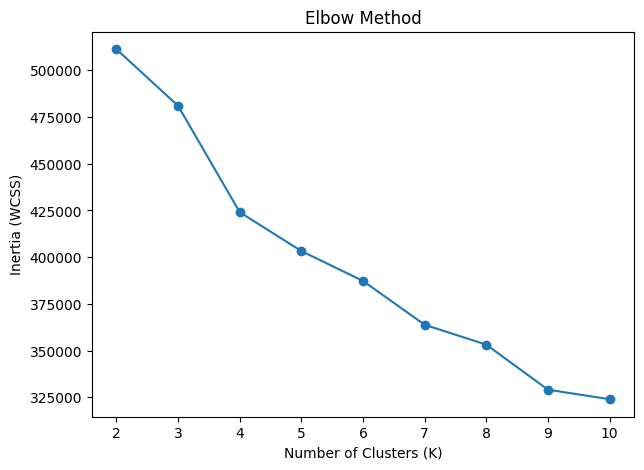

In [19]:
inertias = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method")
plt.show()


In [20]:
k = 4  # change based on elbow

kmeans = KMeans(n_clusters=k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

df['KMeans_Cluster'] = kmeans_labels


In [21]:
kmeans_sil = silhouette_score(X_scaled, kmeans_labels)
print("KMeans Silhouette Score:", round(kmeans_sil, 3))


KMeans Silhouette Score: 0.152


In [22]:
agg = AgglomerativeClustering(n_clusters=k)
agg_labels = agg.fit_predict(X_scaled)

df['Hierarchical_Cluster'] = agg_labels

print("Hierarchical Silhouette:",
      round(silhouette_score(X_scaled, agg_labels), 3))


Hierarchical Silhouette: 0.119


In [23]:
db = DBSCAN(eps=1.5, min_samples=5)
db_labels = db.fit_predict(X_scaled)

df['DBSCAN_Cluster'] = db_labels

mask = db_labels != -1  # ignore noise

if len(set(db_labels[mask])) > 1:
    print("DBSCAN Silhouette:",
          round(silhouette_score(X_scaled[mask], db_labels[mask]), 3))

DBSCAN Silhouette: 0.067


In [24]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df['PC1'] = X_pca[:,0]
df['PC2'] = X_pca[:,1]

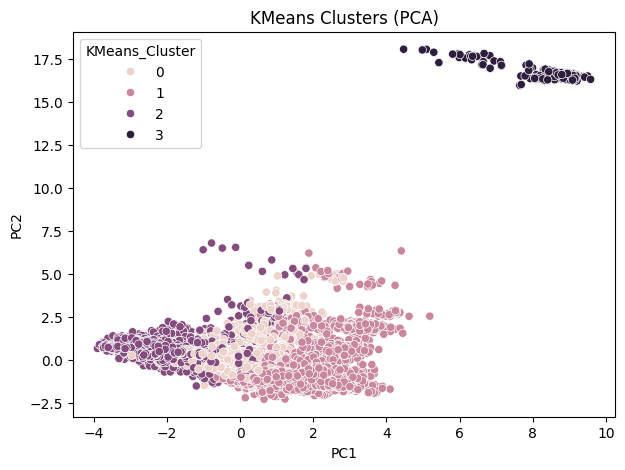

In [25]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='PC1', y='PC2', hue='KMeans_Cluster', data=df)
plt.title("KMeans Clusters (PCA)")
plt.show()

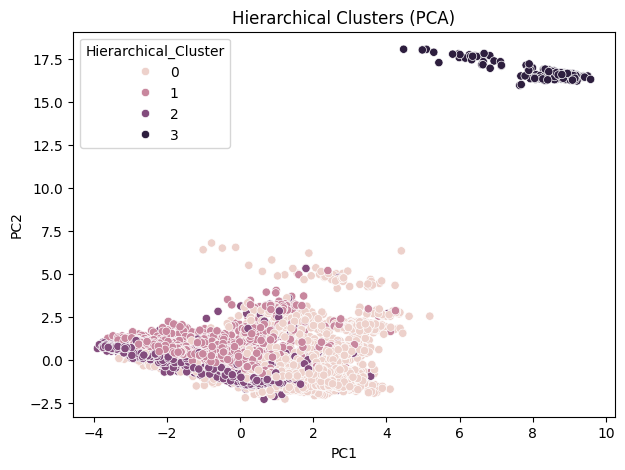

In [26]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='PC1', y='PC2', hue='Hierarchical_Cluster', data=df)
plt.title("Hierarchical Clusters (PCA)")
plt.show()


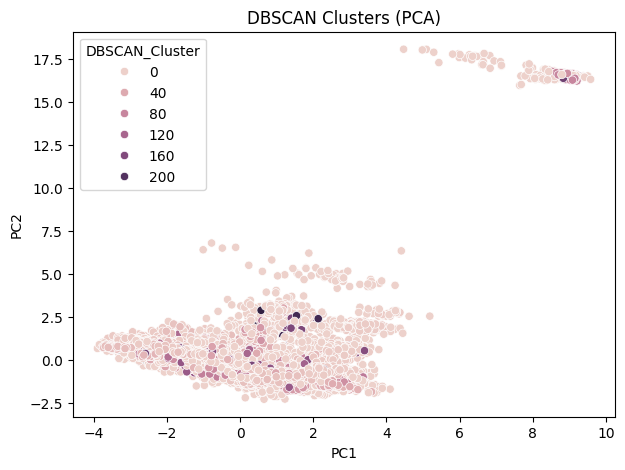

In [28]:
plt.figure(figsize=(7,5))
sns.scatterplot(x='PC1', y='PC2', hue='DBSCAN_Cluster', data=df)
plt.title("DBSCAN Clusters (PCA)")
plt.show()


In [29]:
cluster_summary = df.groupby('KMeans_Cluster')[num_df.columns].mean()
print(cluster_summary)


                     age  workclass    fnlwgt  education  education-num  \
KMeans_Cluster                                                            
0               0.249524  -0.075194 -0.054993   0.053141      -0.007640   
1               0.377506   0.080885 -0.021288   0.008664       0.107739   
2              -0.550599  -0.059220  0.049832  -0.039403      -0.131125   
3               0.569957   0.380375  0.042510   0.318028       1.102983   

                marital-status  occupation  relationship      race       sex  \
KMeans_Cluster                                                                 
0                    -1.318655   -0.135273      0.993522 -0.042600 -0.871943   
1                    -0.384866    0.038149     -0.851865  0.119914  0.695395   
2                     1.071713    0.019671      0.481857 -0.114483 -0.363809   
3                    -0.351639    0.221383     -0.516593  0.052855  0.408931   

                capital-gain  capital-loss  native-country    income

In [30]:
print(df['KMeans_Cluster'].value_counts())


KMeans_Cluster
1    13938
2    12440
0     6000
3      159
Name: count, dtype: int64


# Interpretarea clusterelor
Clusterul 0 – Grupul principal al forței de muncă

    Cel mai mare cluster din setul de date.
    Reprezintă populația tipică în vârstă de muncă.
    Se caracterizează prin niveluri medii de educație și ore de lucru.
    Corespunde probabil lucrătorilor stabili, cu normă întreagă.

Clusterul 1 – Profiluri alternative de angajare

    Cluster puțin mai mic, dar totuși foarte mare.
    Include persoane cu modele de lucru diferite (de exemplu, mai puține ore, ocupații diferite).
    Reprezintă un segment secundar al forței de muncă din cadrul populației

Clusterul 2 – Grupul extrem/atipic

    Cluster foarte mic (159 de persoane)
    Probabil determinat de valori extreme ale variabilelor precum:
    Câștig de capital
    Pierdere de capital
    Capital net

Acest cluster reprezintă profiluri socio-economice atipice sau rare, cum ar fi persoanele cu o activitate financiară neobișnuit de intensă. Prezența acestui cluster este semnificativă și de așteptat în datele reale ale recensământului.

# Limitări

    K-Means presupune clustere sferice și varianță egală.
    Rezultatele sunt sensibile la scalare și selecția caracteristicilor.
    Algoritmul tinde să izoleze valorile extreme în clustere mici.
    Îmbunătățirile viitoare ar putea include:
    DBSCAN pentru clusterizarea bazată pe densitate.
    Clusterizarea ierarhică pentru o mai bună interpretabilitate.
    Analiza siluetei pe datele eșantionate.